# Homework 3

In this assignment, you will create a custom object detection model using PyTorch or Keras.

**Dataset Prep and Preprocessing (20 points):** Collect or create a dataset of images containing the objects you want to detect annotated with bounding boxes. Implement data preprocessing techniques, including resizing images and normalizing pixels.

[Hint. Roboflow has pre-annotated datasets available for download.]

**Model Architecture (30 points):** Train a YOLOv8 model on you selected dataset using the public repository at https://github.com/ultralytics/ultralyticsLinks to an external site.. Monitor training progress and use appropriate techniques to prevent overfitting. (Do at least 3 tuning experiments)

**Evaluation (20 points):** Evaluate your trained model's performance on a test dataset using mAP. Visualize the model's predictions on sample images. Analyze the model's performance, discussing any specific failure modes on your test dataset.

**BONUS (25 bonus points):** Design and train a custom CNN-based object detection model using a self-designed architecture or do a comparison of several publicly available models on the same dataset.

## Dataset Prep and Preprocessing

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.0/654.0 kB 3.9 MB/s eta 0:00:00


In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.9/78.2 GB disk)


First we created a Roboflow account with an api key.

In [ ]:
# Open the file and read the api key
with open('roboflow_key', 'r') as file:
    api_key = file.read().strip()

In [ ]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstal

Then downloaded the UNO cards dataset from Roboflow (https://public.roboflow.com/object-detection/uno-cards):

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key=api_key)
project = rf.workspace("joseph-nelson").project("uno-cards")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.222, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Uno-Cards-1 in yolov8:: 100%|██████████| 43176/43176 [00:08<00:00, 4931.39it/s]


![Image example](https://i.imgur.com/P8jIKjb.jpg)

According to the README file, the following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 416x416 (Stretch)

To work with Yolo, we need to make sure the data is stored in the `datasets` directory.

In [ ]:
# Create dataset directory
!mkdir datasets

# Create sub directory for Uno Cards
!mkdir datasets/Uno-Cards-1

In [ ]:
# Duplicate the Uno cards directory into the datasets folder
!cp -r Uno-Cards-1/. datasets/Uno-Cards-1/

We also need to update `data.yaml` so that the `train` and `val` paths are correct:


```
# Old path
train: Uno-Cards-1/train/images
val: Uno-Cards-1/valid/images

# Corrected path
train: ../train/images
val: ../valid/images
```

In [ ]:
!pip install ruamel.yaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 6.0 MB/s eta 0:00:00


In [ ]:
import ruamel.yaml

# Load the YAML file
file_path = 'datasets/Uno-Cards-1/data.yaml'
yaml = ruamel.yaml.YAML()
with open(file_path, 'r') as file:
    data = yaml.load(file)

# Modify the YAML data
data['train'] = '../train/images'
data['val'] = '../valid/images'

# Save the modified data back to the file
with open(file_path, 'w') as file:
    yaml.dump(data, file)

## Model Architecture

Let's use a pretrained yolo model `yolov8n.pt` to save time, and train our model stored at `data_path` on this model.

In [ ]:
# Declare the path to the yaml file
data_path = '/content/datasets/Uno-Cards-1/data.yaml'

In [ ]:
from ultralytics import YOLO

# Set up the pretrained model
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 77.3MB/s]


In [ ]:
# Train the model to our dataset
results = model.train(data=data_path, epochs=3)

Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/datasets/Uno-Cards-1/data.yaml, epochs=3, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, f

100%|██████████| 755k/755k [00:00<00:00, 17.5MB/s]


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/datasets/Uno-Cards-1/train/labels... 18885 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18885/18885 [00:09<00:00, 2085.03it/s]


train: New cache created: /content/datasets/Uno-Cards-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/Uno-Cards-1/valid/labels... 1798 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1798/1798 [00:01<00:00, 1065.89it/s]


val: New cache created: /content/datasets/Uno-Cards-1/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      2.66G      1.062      2.022     0.9683         16        640: 100%|██████████| 1181/1181 [06:43<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:18<00:00,  3.01it/s]

                   all       1798       5394      0.986       0.99      0.993      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      2.38G     0.7804      0.781     0.8789         22        640: 100%|██████████| 1181/1181 [06:31<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:17<00:00,  3.24it/s]

                   all       1798       5394      0.995      0.997      0.994       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      2.38G     0.7123     0.5994     0.8638         16        640: 100%|██████████| 1181/1181 [06:28<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:17<00:00,  3.21it/s]

                   all       1798       5394      0.996      0.997      0.993      0.857



3 epochs completed in 0.345 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3008573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:23<00:00,  2.42it/s]


                   all       1798       5394      0.996      0.997      0.993      0.857
                     0       1798        370      0.999          1      0.995      0.889
                     1       1798        374      0.999          1      0.995      0.852
                    10       1798        346      0.999          1      0.995      0.842
                    11       1798        367          1          1      0.995      0.865
                    12       1798        353          1      0.999      0.995      0.856
                    13       1798        340      0.962      0.957      0.961       0.71
                    14       1798        374      0.994          1      0.995      0.857
                     2       1798        368          1          1      0.995      0.866
                     3       1798        374      0.999          1      0.995      0.883
                     4       1798        351      0.999          1      0.995      0.866
                     

Next, we can tune our hyperparameters using the built-in `tune()` method. This will allow us to run multiple tuning experiments without manually tuning ourselves. In addition, we'll be using skipping plotting, checkpointing and validation other than on final epoch for faster Tuning.



In [ ]:
# Tune hyperparameters
model.tune(data=data_path, epochs=3, iterations=5, plots=False, save=False, val=False)

Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/tune'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/5 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Saved runs/detect/tune/tune_scatter_plots.png
Saved runs/detect/tune/tune_fitness.png

Tuner: 1/5 iterations complete ✅ (1216.79s)
Tuner: Results saved to runs/detect/tune
Tuner: Best fitness=0.87032 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.99638, 'metrics/recall(B)': 0.99689, 'metrics/mAP50(B)': 0.99272, 'metrics/mAP50-95(B)': 0.85673, 'val/box_loss': 0.58839, 'val/cls_loss': 0.36969, 'val/

Overall, as the model was tuned over multiple trials and epochs, it seems some parameters were more impactful than others.

In particular, the learning rates `lr0` and `lrf` were pivotal, affecting the pace at which the model adapts to the training data and refines its predictions. In addition, `momentum` and `weight_decay` played crucial roles in regulating the optimization process, influencing the model's ability to generalize and avoid overfitting.

## Evaluation

We can then evaluate our model using `.val()`, while using mAP.

In [ ]:
metrics = model.val()

Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3008573 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/datasets/Uno-Cards-1/valid/labels.cache... 1798 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1798/1798 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:24<00:00,  4.62it/s]


                   all       1798       5394      0.997      0.997      0.993      0.857
                     0       1798        370      0.999          1      0.995      0.891
                     1       1798        374      0.999          1      0.995      0.856
                    10       1798        346      0.998          1      0.995      0.843
                    11       1798        367          1          1      0.995      0.866
                    12       1798        353          1      0.999      0.995      0.857
                    13       1798        340      0.965       0.96       0.96       0.71
                    14       1798        374      0.994          1      0.995      0.854
                     2       1798        368          1          1      0.995      0.869
                     3       1798        374      0.999          1      0.995      0.884
                     4       1798        351      0.999          1      0.995      0.866
                     

In [ ]:
metrics.box.map

0.8574130023634795

All of these mAP values seem to be very good, averaging around 0.995 for mAP50 and 0.85 for mAP50-95, which are close enough to the targetted value of 1 to be satisfiable.

Finally, let's test our model against some sample images.

![Sample hand](https://t4.ftcdn.net/jpg/04/06/19/57/360_F_406195743_pZ3WDozhsp4MzPCR3b0RCNlog5zXr8kX.jpg)

In [ ]:
# Perform object detection on an image using the model
image_path = 'https://t4.ftcdn.net/jpg/04/06/19/57/360_F_406195743_pZ3WDozhsp4MzPCR3b0RCNlog5zXr8kX.jpg'
detection = model(image_path)


Found https://t4.ftcdn.net/jpg/04/06/19/57/360_F_406195743_pZ3WDozhsp4MzPCR3b0RCNlog5zXr8kX.jpg locally at 360_F_406195743_pZ3WDozhsp4MzPCR3b0RCNlog5zXr8kX.jpg
image 1/1 /content/360_F_406195743_pZ3WDozhsp4MzPCR3b0RCNlog5zXr8kX.jpg: 448x640 1 10, 1 13, 1 3, 1 5, 1 8, 14.3ms
Speed: 3.2ms preprocess, 14.3ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)


In [ ]:
# Run inference
model.predict(image_path, save=True)


Found https://t4.ftcdn.net/jpg/04/06/19/57/360_F_406195743_pZ3WDozhsp4MzPCR3b0RCNlog5zXr8kX.jpg locally at 360_F_406195743_pZ3WDozhsp4MzPCR3b0RCNlog5zXr8kX.jpg
image 1/1 /content/360_F_406195743_pZ3WDozhsp4MzPCR3b0RCNlog5zXr8kX.jpg: 448x640 1 10, 1 13, 1 3, 1 5, 1 8, 17.2ms
Speed: 2.6ms preprocess, 17.2ms inference, 5.1ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/train8


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: '0', 1: '1', 2: '10', 3: '11', 4: '12', 5: '13', 6: '14', 7: '2', 8: '3', 9: '4', 10: '5', 11: '6', 12: '7', 13: '8', 14: '9'}
 orig_img: array([[[139, 130, 150],
         [139, 130, 150],
         [139, 130, 150],
         ...,
         [203, 190, 198],
         [204, 191, 199],
         [204, 191, 199]],
 
        [[139, 130, 150],
         [139, 130, 150],
         [139, 130, 150],
         ...,
         [203, 190, 198],
         [203, 190, 198],
         [204, 191, 199]],
 
        [[138, 129, 149],
         [138, 129, 149],
         [138, 129, 149],
         ...,
         [202, 189, 197],
         [203, 190, 198],
         [203, 190, 198]],
 
        ...,
 
        [[143, 131, 149],
         [144, 132, 150],
         [144, 132, 150],
         ...,
         [142, 129, 143],
         [142, 129, 143],
         [142, 129, 143]],
 
    

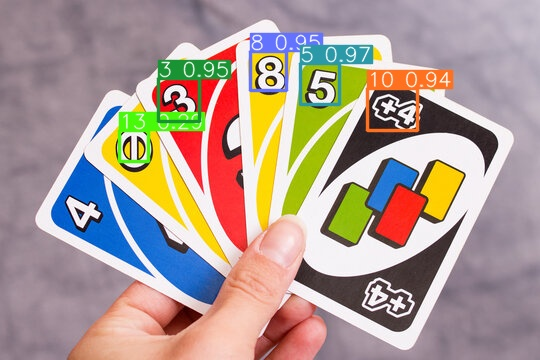

In [ ]:
from IPython.display import Image, display

# Path to the output image file
output_image = '/content/runs/detect/train8/360_F_406195743_pZ3WDozhsp4MzPCR3b0RCNlog5zXr8kX.jpg'

# Display the output image
display(Image(filename=output_image))

All in all, the creation and tuning of our model was very smoothfoward using the built-in YOLO functions. The tuning function in particular was extremely handy in allowing us to hypertune without manual input, and although it took a significant amount of time, it was very much worth it as shown by the mAP values acquired.

The only visible failure in our model can be seen in the last outputed image in which the blue 4 card was not detected. It is possible that the detection is limited in how many entities it can deal with, or the card angle was simply too unexpected for the model to handle. Future work could involve fixing these types of issues by exploring the capabilities of the YOLO prediction, and may also be fixed by including a dataset with more variation in terms of card positioning.